 # Working Notebook

 This is a notebook to keep an up-to-date working version of the project.

In [1]:
# Import required modules
from myModule import *


In [2]:
# Import PAIPR-generated data
PAIPR_dir = ROOT_DIR.joinpath('data/gamma_20111109')
data_0 = import_PAIPR(PAIPR_dir)


In [3]:
# 
accum_long = format_PAIPR(data_0, start_yr=1979, end_yr=2009)
traces = accum_long.groupby('trace_ID')

# New accum and std dfs in wide format
accum = accum_long.pivot(
    index='trace_ID', columns='Year', values='accum')
accum_std = accum_long.pivot(
    index='trace_ID', columns='Year', values='std')

# Create df for mean annual accumulation
accum_mu = traces.aggregate(np.mean).drop('Year', axis=1)
accum_mu = gpd.GeoDataFrame(
    accum_mu, geometry=gpd.points_from_xy(
        accum_mu.Lon, accum_mu.Lat)
).drop(['Lat', 'Lon', 'elev'], axis=1)
accum_mu.crs = "EPSG:4326"

# Create a gdf from accum df
accum_gdf = gpd.GeoDataFrame(
    accum, geometry=gpd.points_from_xy(
        traces.aggregate(np.mean)['Lon'], 
        traces.aggregate(np.mean)['Lat'])
)
accum_gdf.crs = "EPSG:4326"



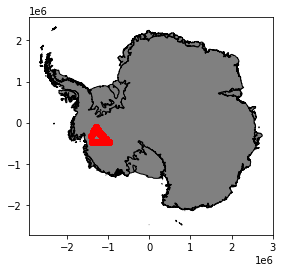

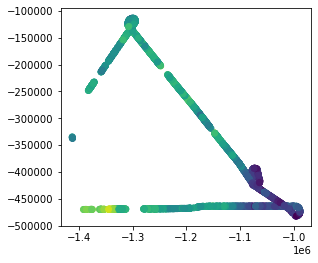

In [4]:
# Import Antarctic outline shapefile
ant_path = ROOT_DIR.joinpath(
    'data/Ant_basemap/Coastline_medium_res_polygon.shp')
ant_outline = gpd.read_file(ant_path)

# Convert accum crs to same as Antarctic outline
accum_gdf = accum_gdf.to_crs(ant_outline.crs)
accum_mu = accum_mu.to_crs(ant_outline.crs)

# Plot inset map
base = ant_outline.plot(color='grey', edgecolor='black')
accum_gdf.sample(n=1000).plot(ax=base, color='red')

# Plot mean accumulation spatial map
accum_mu.sample(n=2500).plot(column='accum')



 We used the below code to find and download required digital surface model data from REMA.
 To save time and to avoid unnecessarily large file uploads for this project, we leave this code commented out and simply load a dataset containing the necessary data at a later point.

In [ ]:

# # Define path to index shapefile
# index_file = ROOT_DIR.joinpath("data/REMA", 
#     "REMA_Tile_Index_Rel1.1", "REMA_Tile_Index_Rel1.1.shp")

# # Import shapefile of DEM tile locations
# dem_index = gpd.read_file(index_file)

# # Keep only DEMs that contain accum traces
# dem_index = (
#     gpd.sjoin(dem_index, accum_mu, op='contains')
#     .iloc[:,0:dem_index.shape[1]]).drop_duplicates()

# # Find and download missing REMA DSM tiles
# REMA_outdir = ROOT_DIR.joinpath("data/REMA/tiles_8m_v1.1")
# tiles_list = pd.DataFrame(
#     dem_index.drop(columns='geometry'))
# # For development purposes, only using first 2 tiles
# # get_REMA(tiles_list, REMA_outdir) 
# get_REMA(tiles_list[:2], REMA_outdir) 


 We next calculate the slope and aspect using the downloaded DSM data.
 We also extract the elevation, slope, and aspect values at each trace location and add these to the dataframe containing the accumulation data.
 Similar to the above step, to avoid large file sizes we performed these calculations previously, and instead load the final product.

In [ ]:

# # Generate list of paths to downloaded DEMs for topo
# #  calculations
# REMA_dir = ROOT_DIR.joinpath("data/REMA/tiles_8m_v1.1")
# dem_list = [path for path in REMA_dir.glob('**/*dem.tif')]

# # Calculate slope and aspect for each DEM
# # For development purposes, only processing first in list
# # [calc_topo(dem) for dem in dem_list]
# [calc_topo(dem) for dem in dem_list[:1]]

# # Extract elevation, slope, and aspect values for each trace 
# # location
# raster_vals = accum_mu.drop(['accum', 'std'], axis=1)
# tif_dirs = [path.parent for path in dem_list[:1]]
# for path in tif_dirs:
#     raster_vals = topo_vals(path, raster_vals)

# # Save raster_vals to GeoJSON
# file_out = ROOT_DIR.joinpath('data/REMA/raster_vals.geojson')
# raster_vals.to_file(file_out, driver='GeoJSON')


 We now load the pre-processed data results generated using the REMA raster data.

In [5]:

raster_vals = gpd.read_file(
    ROOT_DIR.joinpath('data/REMA/raster_vals.geojson'))

We then download the ERA5 reanalysis gridded climate data using the online API. To save time and avoid unnecessarily large files (and also because it requires login credentials to download), we comment out the code and simply load the data at a later step.

In [ ]:
# def Download_ERA5():
    
#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     ## Imports
    
#     import cdsapi
#     import netCDF4
#     import numpy as np
    
#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     ## Download ERA5 variables into files
    
#     # 10-m u-component of wind
#     c = cdsapi.Client()
#     r = c.retrieve(
#         'reanalysis-era5-land-monthly-means', {
#                 'format'      : 'netcdf',
#                 'product_type': 'monthly_averaged_reanalysis',
#                 'variable'    : '10m_u_component_of_wind',
#                 'stream'      : 'moda',
#                 'year'        : [
#                     '1980','1981','1982','1983','1984','1985','1986','1987','1988',
#                     '1989','1990','1991','1992','1993','1994','1995','1996','1997',
#                     '1998','1999','2000','2001','2002','2003','2004','2005','2006',
#                     '2007','2008','2009','2010','2011','2012','2013','2014','2015'
#                     ],
#                 'month'       : [
#                     '01','02','03','04','05','06','07','08','09','10','11','12'
#                     ],
#                 'time'        : '00:00'
#         })
#     r.download('10m_u_component_of_wind.nc')
    
    
#     # 10-m v component of wind
#     r = c.retrieve(
#         'reanalysis-era5-land-monthly-means', {
#                 'format'      : 'netcdf',
#                 'product_type': 'monthly_averaged_reanalysis',
#                 'variable'    : '10m_v_component_of_wind',
#                 'stream'      : 'moda',
#                 'year'        : [
#                     '1980','1981','1982','1983','1984','1985','1986','1987','1988',
#                     '1989','1990','1991','1992','1993','1994','1995','1996','1997',
#                     '1998','1999','2000','2001','2002','2003','2004','2005','2006',
#                     '2007','2008','2009','2010','2011','2012','2013','2014','2015'
#                     ],
#                 'month'       : [
#                     '01','02','03','04','05','06','07','08','09','10','11','12'
#                     ],
#                 'time'        : '00:00'
#         })
#     r.download('10m_v_component_of_wind.nc')
    
    
#     # Total precipitation
#     r = c.retrieve(
#         'reanalysis-era5-land-monthly-means', {
#                 'format'      : 'netcdf',
#                 'product_type': 'monthly_averaged_reanalysis',
#                 'variable'    : 'total_precipitation',
#                 'stream'      : 'moda',
#                 'year'        : [
#                     '1980','1981','1982','1983','1984','1985','1986','1987','1988',
#                     '1989','1990','1991','1992','1993','1994','1995','1996','1997',
#                     '1998','1999','2000','2001','2002','2003','2004','2005','2006',
#                     '2007','2008','2009','2010','2011','2012','2013','2014','2015'
#                     ],
#                 'month'       : [
#                     '01','02','03','04','05','06','07','08','09','10','11','12'
#                     ],
#                 'time'        : '00:00'
#         })
#     r.download('total_precipitation.nc')
    

#     return

We then load the ERA5 data and clip it down to only the required extents for this project.

In [ ]:
def Load_ERA5():
    
    import netCDF4
    import numpy as np
    
    # Extents
    iLat_min = -75.58234
    iLat_max = -79.9461
    iLon_min = -115.86289
    iLon_max = -75.58234
    
    # Extract lat/lon data
    data = netCDF4.Dataset('10m_u_component_of_wind.nc')
    vLat = data.variables['latitude']
    vLat = np.asarray(vLat[:])
    vLon = data.variables['longitude']
    vLon = np.asarray(vLon[:])
    vLon[vLon > 180] = -(360 - vLon[vLon > 180]) # Is this right? What's with the 360 deg latitudes?
    vTime = data.variables['time']
    vTime = vTime[:]
    
    # Find indices for required extents
    iLat_min_idx = np.argmin(np.abs(vLat-iLat_min))
    iLat_max_idx = np.argmin(np.abs(vLat-iLat_max))
    iLon_min_idx = np.argmin(np.abs(vLon-iLon_min))
    iLon_max_idx = np.argmin(np.abs(vLon-iLon_max))
    
    # Read NetCDF files
    data = netCDF4.Dataset('10m_u_component_of_wind.nc')
    wind_u_10m = data.variables['u10']
    data = netCDF4.Dataset('10m_v_component_of_wind.nc')
    wind_v_10m = data.variables['v10']
    data = netCDF4.Dataset('total_precipitation.nc')
    precip = data.variables['tp']
    
    # Extract required portions of each variable
    wind_u_10m = wind_u_10m[:,iLat_min_idx:iLat_max_idx,iLon_min_idx:iLon_max_idx]
    wind_v_10m = wind_v_10m[:,iLat_min_idx:iLat_max_idx,iLon_min_idx:iLon_max_idx]
    precip = precip[:,iLat_min_idx:iLat_max_idx,iLon_min_idx:iLon_max_idx] 
    vLat = vLat[iLat_min_idx:iLat_max_idx]
    vLon = vLon[iLon_min_idx:iLon_max_idx]
    
    # ERA5 Elevations
    data = netCDF4.Dataset('ERA5_Orography.nc')
    elv_Lat = data.variables['latitude']
    elv_Lat = elv_Lat[:]
    elv_Lon = data.variables['longitude']
    elv_Lon = elv_Lon[:]
    elv_orog = data.variables['z'] # Surface geopotential
    elv_orog = elv_orog[:,:,:]
    g = 9.80665 # Gravity
    mElev = elv_orog/g # Surface geopotential height = surface geopotential / gravity
    
    return wind_u_10m, wind_v_10m, precip, vLat, vLon, vTime, mElev

Next, the ERA5 data are downscaled from their native low resolution to a higher resolution using a simple linear interpolation method. This portion of the code is still under development, and thus does not currently run. It is being included here only to show where the current progress of the project is at, but remains commented out.


In [ ]:
# def Downscale_ERA5(wind_u_10m, wind_v_10m, precip, vLat_ERA, vLon_ERA, vTime):

#     import utm
#     import numpy as np

#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     # Load ERA5 data
    
#     # wind_u, wind_v, precip
#     # iLat_min, iLat_max, iLong_min, iLong_max
#     # Elevation_ERA5

#     mElevations_ERA5 = [[1,2,3], [4,5,6], [7,8,9]] # placeholder
    
    
#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     # Load REMA DEM
#     # mDEM
#     # iLat_min, iLat_max, iLong_min, iLong_max
#     # iResolution

#     mLat_REMA = 0 # placeholder
#     mLon_REMA = 0 # placeholder

#     vLat_REMA = mREMA_Lat[:,1] # placeholder
#     vLon_REMA = mREMA_Lon[1,:] # placeholder
    
#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     # Mask out areas with radar trace data
    
#     mMask_ERA  = 0 # placeholder
#     mMask_REMA = 0 # placeholder

#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     # Convert lat/lon to gridded UTM
    
#     # ERA5
#     mEasting_ERA = np.zeros([len(vLat_ERA),len(vLon_ERA)])
#     mNorthing_ERA = np.zeros([len(vLat_ERA),len(vLon_ERA)])
        
#     for lat_idx in range(len(vLat_ERA)):
#         lat = vLat_ERA(lat_idx)
#         for lon_idx in range(len(vLon_ERA)):
#             lon = vLon_ERA(lon_idx)
#             easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
#             mEasting_ERA[lat_idx,lon_idx]  = easting
#             mNorthing_ERA[lat_idx,lon_idx] = northing
            
#     # REMA
#     mEasting_REMA = np.zeros([len(vLat_REMA),len(vLon_REMA)])
#     mNorthing_REMA = np.zeros([len(vLat_REMA),len(vLon_REMA)])
        
#     for lat_idx in range(len(vLat_REMA)):
#         lat = vLat_REMA(lat_idx)
#         for lon_idx in range(len(vLon_REMA)):
#             lon = vLon_REMA(lon_idx)
#             easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
#             mEasting_REMA[lat_idx,lon_idx]  = easting
#             mNorthing_REMA[lat_idx,lon_idx] = northing

#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     # Downscale ERA at each point onto high resolution (DEM) grid
            
#     mWindU_hd  = np.zeros(np.shape(mEasting_REMA))
#     mWindV_hd  = np.zeros(np.shape(mEasting_REMA))
#     mPrecip_hd = np.zeros(np.shape(mEasting_REMA))

#     for m in range(np.shape(mEasting_REMA)[0]):
#         for n in range(np.shape(mEasting_REMA)[1]):
#             try: # try/except necessary to avoid edges of ERA5 data matrix
                
#                 # Find indices of nearest ERA grid point
#                 iERA_e_idx = (np.abs(mEasting_ERA  -  mEasting_REMA(m,n))).argmin() # does this find index or value? want index
#                 iERA_n_idx = (np.abs(mNorthing_ERA - mNorthing_REMA(m,n))).argmin() # does this find index or value? want index
#                 # Calculate distances to nearest ERA5 grid points
#                 m3x3_ERA_Easting  =  mEasting_ERA[iERA_e_idx-1:iERA_e_idx+1,iERA_n_idx-1:iERA_n_idx+1]
#                 m3x3_ERA_Northing = mNorthing_ERA[iERA_e_idx-1:iERA_e_idx+1,iERA_n_idx-1:iERA_n_idx+1]
#                 m3x3_Distances = np.sqrt( (m3x3_ERA_Easting - mEasting_REMA[m,n])**2 + (m3x3_ERA_Northing - mNorthing_REMA[m,n])**2 )
#                 m3x3_Weights = m3x3_Distances / sum(m3x3_Distances[:])
#                 # Calculate weighted mean (based on distance) of surrounding ERA5 values
#                 temp = m3x3_Weights * wind_u_10m[iERA_e_idx-1:iERA_e_idx+1,iERA_n_idx-1:iERA_n_idx+1]
#                 mWindU_hd[m,n] = sum(temp[:])
#                 temp = m3x3_Weights * wind_v_10m[iERA_e_idx-1:iERA_e_idx+1,iERA_n_idx-1:iERA_n_idx+1]
#                 mWindV_hd[m,n] = sum(temp[:])
#                 temp = m3x3_Weights * precip[iERA_e_idx-1:iERA_e_idx+1,iERA_n_idx-1:iERA_n_idx+1]
#                 mPrecip_hd[m,n] = sum(temp[:])
                
#             except:
#                 pass
            
#     return